# Set up Data

In [1]:
!pip install -U gdown
import gdown

url="https://drive.google.com/file/d/1WEySXMFz6v1OgPkLKJ8QIp3Lk-eyTObY/view"
id="1WEySXMFz6v1OgPkLKJ8QIp3Lk-eyTObY"
gdown.download(f'https://drive.google.com/uc?id={id}', quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1WEySXMFz6v1OgPkLKJ8QIp3Lk-eyTObY
From (redirected): https://drive.google.com/uc?id=1WEySXMFz6v1OgPkLKJ8QIp3Lk-eyTObY&confirm=t&uuid=00af809e-d870-4d14-9866-62197039f701
To: /content/Teeth DataSet.zip
100%|██████████| 49.1M/49.1M [00:01<00:00, 39.9MB/s]


'Teeth DataSet.zip'

In [2]:
import zipfile

with zipfile.ZipFile('/content/Teeth DataSet.zip', 'r') as zip_ref:
    zip_ref.extractall('Teeth_DataSet')

# Needed Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import glob
from PIL import Image
import cv2
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,Input
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard


# Explore the Data

issus in the data:
* it conytain 1 image wich is 4-Channel Image

In [4]:
train_dir="/content/Teeth_DataSet/Teeth_Dataset/Training"
test_dir="/content/Teeth_DataSet/Teeth_Dataset/Testing"
val_dir="/content/Teeth_DataSet/Teeth_Dataset/Validation"

In [5]:
os.listdir(train_dir)

['OT', 'CaS', 'OLP', 'Gum', 'CoS', 'MC', 'OC']

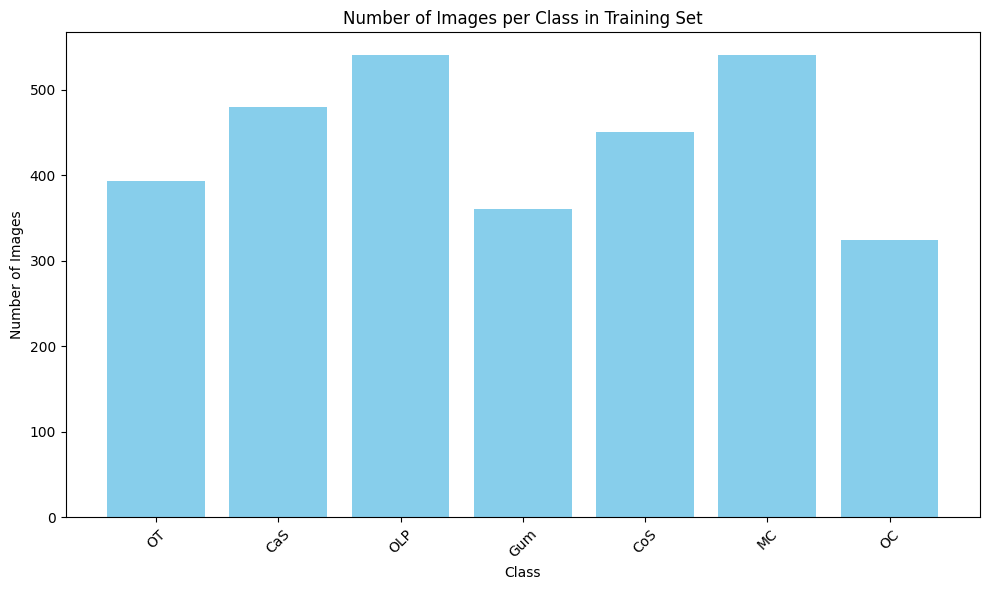

In [6]:
class_counts = {}
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        image_count = len(os.listdir(class_path))
        class_counts[class_name] = image_count

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Number of Images per Class in Training Set")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

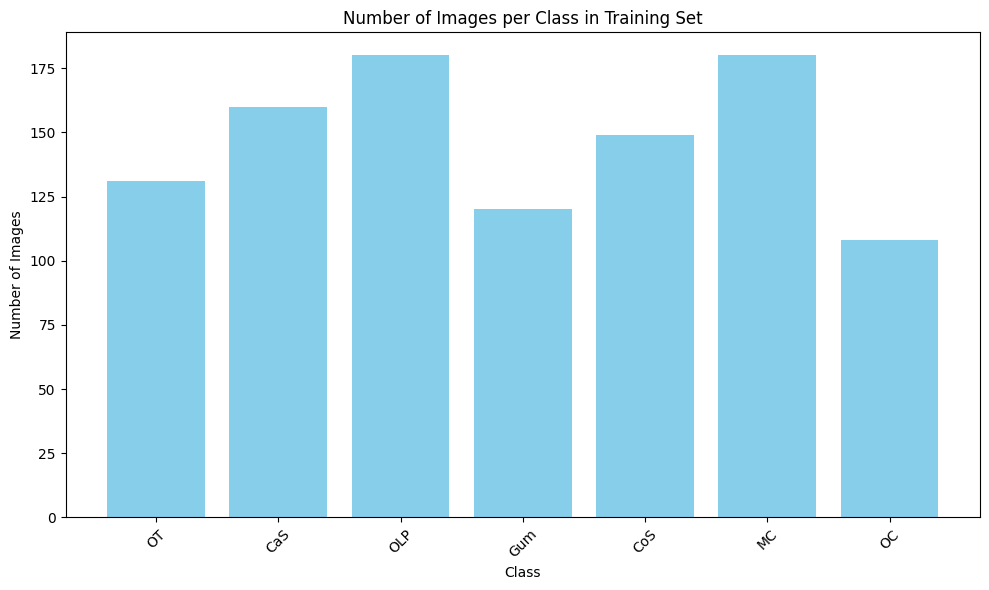

In [7]:
class_counts = {}
for class_name in os.listdir(val_dir):
    class_path = os.path.join(val_dir, class_name)
    if os.path.isdir(class_path):
        image_count = len(os.listdir(class_path))
        class_counts[class_name] = image_count

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Number of Images per Class in Training Set")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
img_size=[]
for folder in os.listdir(train_dir):
  folder_path=glob.glob(train_dir+'/'+folder+'/*')
  for img_path in folder_path:
    img=plt.imread(img_path)
    img_size.append(img.shape)

In [9]:
pd.Series(img_size).value_counts()

,count
"(256, 256, 3)",3086
"(256, 256, 4)",1


Convert 4-Channel Images to 3 Channels

In [10]:
for folder in os.listdir(train_dir):
  folder_path = glob.glob(train_dir + '/' + folder + '/*')
  for img_path in folder_path:
    img = plt.imread(img_path)
    if img.shape[-1] == 4:  # Image has 4 channels
      print(f"Deleting: {img_path}")
      os.remove(img_path)

Deleting: /content/Teeth_DataSet/Teeth_Dataset/Training/Gum/g_1207.jpg


In [11]:
img_size=[]
for folder in os.listdir(train_dir):
  folder_path=glob.glob(train_dir+'/'+folder+'/*')
  for img_path in folder_path:
    img=plt.imread(img_path)
    img_size.append(img.shape)

In [12]:
pd.Series(img_size).value_counts()

,count
"(256, 256, 3)",3086


In [13]:
train_gen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2
)
test_gen=ImageDataGenerator(rescale=1./255)
val_gen=ImageDataGenerator(rescale=1./255)

In [14]:
train=train_gen.flow_from_directory(
    train_dir,
    target_size=(256,256),
    class_mode='categorical',
    batch_size=32
)
test=test_gen.flow_from_directory(
    test_dir,
    target_size=(256,256),
    class_mode='categorical',
    batch_size=32
)
val=val_gen.flow_from_directory(
    val_dir,
    target_size=(256,256),
    class_mode='categorical',
    batch_size=32
)

Found 3086 images belonging to 7 classes.
Found 1508 images belonging to 10 classes.
Found 1028 images belonging to 7 classes.


In [16]:
train.class_indices

{'CaS': 0, 'CoS': 1, 'Gum': 2, 'MC': 3, 'OC': 4, 'OLP': 5, 'OT': 6}

In [17]:
len(train)

97

In [18]:
class_labels = {v: k for k, v in train.class_indices.items()}  # Reverse the  dictionary
class_labels

{0: 'CaS', 1: 'CoS', 2: 'Gum', 3: 'MC', 4: 'OC', 5: 'OLP', 6: 'OT'}

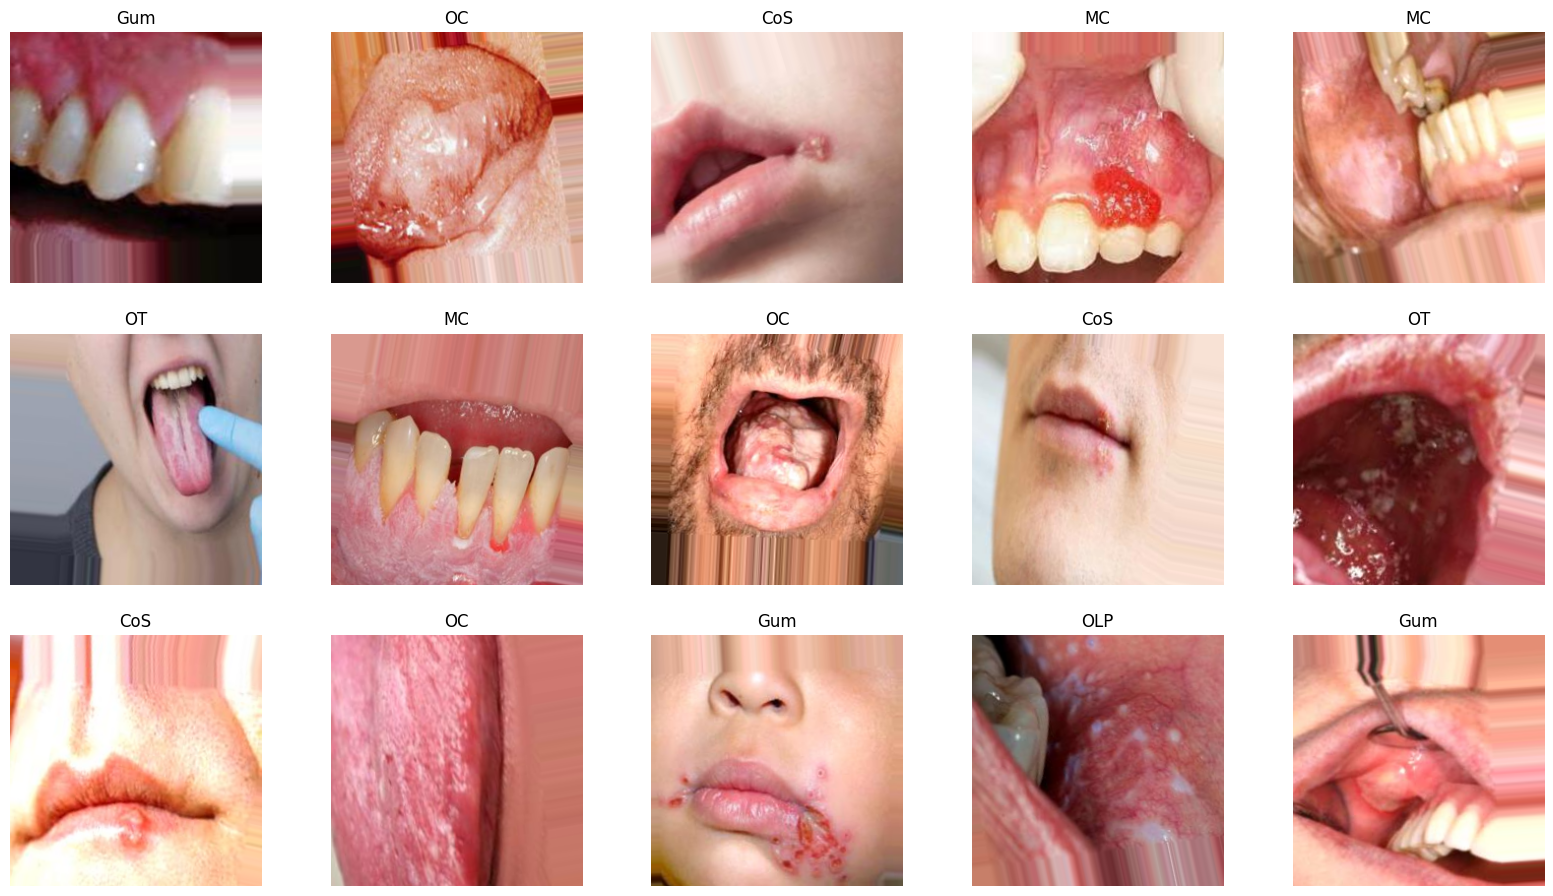

In [19]:
plt.figure(figsize=(20 ,15))
for image_batch, labels_batch in train:
    image = image_batch[1]
    for i in range(1, 16):
        plt.subplot(4, 5, i)
        plt.imshow(image_batch[i])
        label = class_labels[np.argmax(labels_batch[i])]
        plt.title(label)
        plt.axis("off")
    break
    plt.show()

# Modeling

In [20]:
model=Sequential([
    Input(shape=(256,256,3)),
    Conv2D(32,3,activation='relu'),
    MaxPooling2D(),
    Conv2D(64,3,activation='relu'),
    MaxPooling2D(),
    Conv2D(128,3,activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128,activation='relu'),
    Dropout(0.2),
    Dense(64,activation='relu'),
    Dropout(0.2),
    Dense(7,activation='softmax')
  ])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,687 (56.64 MB)

 Trainable params: 14,847,687 (56.64 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
%load_ext tensorboard

In [22]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

lr_schedul = ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    verbose=1,
    factor=0.2,
    min_lr=1e-8
)

model_name = "model.keras"
checkpoint = ModelCheckpoint(
    model_name,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    verbose=1
)

# TensorBoard callback
log_dir = "logs/fit"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


In [23]:
history = model.fit(
    train,
    validation_data=val,
    epochs=60,
    callbacks=[early_stopping,lr_schedul,checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/60
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1874 - loss: 2.0782
Epoch 1: val_loss improved from inf to 1.93038, saving model to model.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 473s 5s/step - accuracy: 0.1873 - loss: 2.0771 - val_accuracy: 0.1955 - val_loss: 1.9304 - learning_rate: 0.0010
Epoch 2/60
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2015 - loss: 1.9039
Epoch 2: val_loss improved from 1.93038 to 1.84459, saving model to model.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 501s 5s/step - accuracy: 0.2017 - loss: 1.9037 - val_accuracy: 0.2393 - val_loss: 1.8446 - learning_rate: 0.0010
Epoch 3/60
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2303 - loss: 1.8602
Epoch 3: val_loss improved from 1.84459 to 1.76709, saving model to model.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 466s 5s/step - accuracy: 0.2304 - loss: 1.8601 - val_accuracy: 0.2811 - val_loss: 1.7671 - learning_rate: 0.0010
Epoch 4/60
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2710 - loss: 1.8157
Epoch 4: val

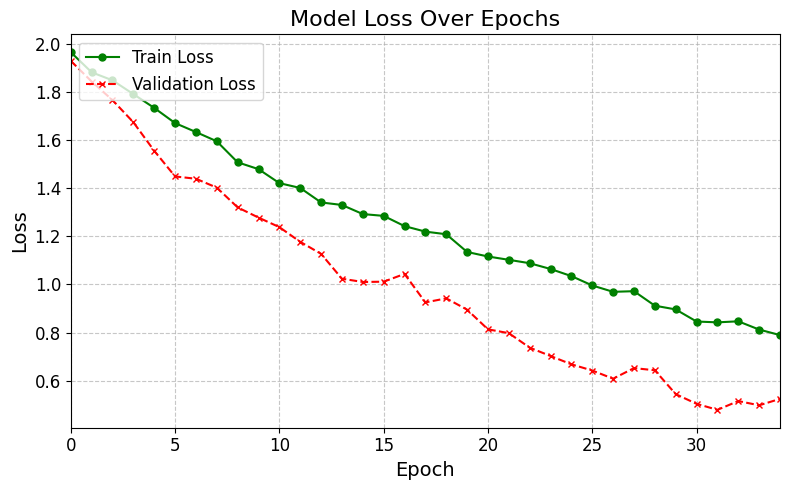

In [24]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], color='green', linestyle='-', marker='o', markersize=5, label='Train Loss')
plt.plot(history.history['val_loss'], color='red', linestyle='--', marker='x', markersize=5, label='Validation Loss')

plt.title('Model Loss Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)

plt.legend(loc='upper left', fontsize=12)

plt.xlim(0, len(history.history['loss']) - 1)

plt.tight_layout()
plt.show()


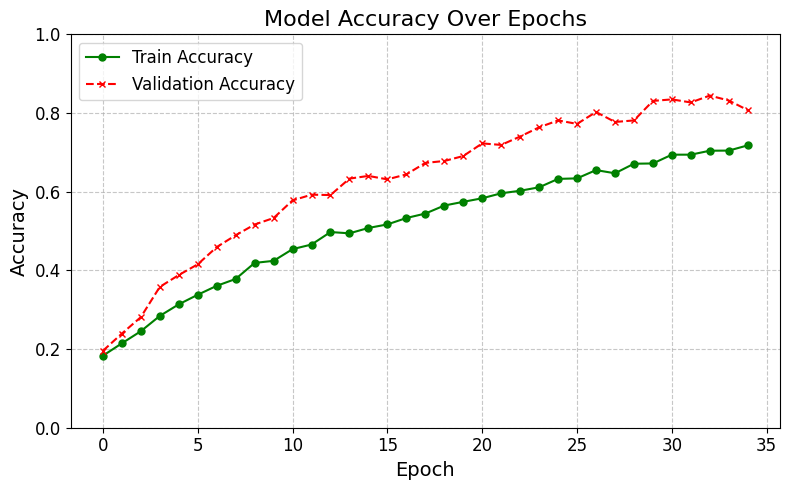

In [25]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], color='green', linestyle='-', marker='o', markersize=5, label='Train Accuracy')
plt.plot(history.history['val_accuracy'], color='red', linestyle='--', marker='x', markersize=5, label='Validation Accuracy')

plt.title('Model Accuracy Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)

plt.legend(loc='upper left', fontsize=12)

plt.ylim(0, 1)

plt.tight_layout()
plt.show()


In [26]:
model.evaluate(test)

InvalidArgumentError: Graph execution error:

Detected at node compile_loss/categorical_crossentropy/softmax_cross_entropy_with_logits defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipython-input-26-3544364825.py", line 1, in <cell line: 0>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 484, in evaluate

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 113, in one_step_on_data

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 92, in test_step

  File "/usr/local/lib/python3.11/dist-packages/keras/src/trainers/trainer.py", line 383, in _compute_loss

  File "/usr/local/lib/python3.11/dist-packages/keras/src/trainers/trainer.py", line 351, in compute_loss

  File "/usr/local/lib/python3.11/dist-packages/keras/src/trainers/compile_utils.py", line 691, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/trainers/compile_utils.py", line 700, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/losses/loss.py", line 67, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/losses/losses.py", line 33, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/losses/losses.py", line 2097, in categorical_crossentropy

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py", line 1878, in categorical_crossentropy

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py", line 670, in categorical_crossentropy

logits and labels must be broadcastable: logits_size=[32,7] labels_size=[32,10]
	 [[{{node compile_loss/categorical_crossentropy/softmax_cross_entropy_with_logits}}]] [Op:__inference_multi_step_on_iterator_66929]